# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# ⬇ Install

In [ ]:
# %%capture
# !conda update pandas

# 🌴 Environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
import os
import sagemaker
from sagemaker import image_uris, model_uris, script_uris
from sagemaker import hyperparameters
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
PROCESSED_DATA_DIR = 'processed_data'

# 💿 Data Overview

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 📂 Portfolio

In [5]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Convert the channels column to multiple boolean columns

In [6]:
portfolio_df = portfolio.copy()

In [7]:
portfolio_df['channels'].dtype

dtype('O')

In [8]:
portfolio_df['channels'] = portfolio_df['channels'].astype(str)
portfolio_df['channels'].unique()

array(["['email', 'mobile', 'social']",
       "['web', 'email', 'mobile', 'social']",
       "['web', 'email', 'mobile']", "['web', 'email']"], dtype=object)

From the above analysis it appears that we have 4 unique channels which are web, email, mobile and social

In [9]:
vals_dict = {
    'email': [],
    'mobile': [],
    'web': [],
    'social': []
}

In [10]:
for i in range(len(portfolio_df)):
    channels_lst = portfolio_df.loc[i, 'channels']
    for channel in vals_dict.keys():
        if channel in channels_lst:
            vals_dict[channel].append(True)
        else:
            vals_dict[channel].append(False)

In [11]:
temp_df = pd.DataFrame(vals_dict)
temp_df.head(5)

,email,mobile,web,social
0,True,True,False,True
1,True,True,True,True
2,True,True,True,False
3,True,True,True,False
4,True,False,True,False


In [12]:
portfolio_df = pd.concat([portfolio_df, temp_df], axis=1)
portfolio_df.head(5)

,reward,channels,difficulty,duration,offer_type,id,email,mobile,web,social
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,True,True,False,True
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,True,False


In [13]:
portfolio_df = portfolio_df.drop('channels', axis=1)

In [14]:
portfolio_df = portfolio_df.set_index('id')
portfolio_df.head(10)

,reward,difficulty,duration,offer_type,email,mobile,web,social
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,True,True,False,True
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,True,True,True,True
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,True,True,True,False
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,True,True,True,False
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,True,False,True,False
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,True,True,True,True
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,True,True,True,True
5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,True,True,False,True
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,True,True,True,True


## 📃Transcript

In [15]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
val_dict = {
    'offer_id': [],
    'amount' : []
}
for i in range(len(transcript)):
    temp = dict(transcript.loc[i, 'value'])
    key = list(temp.keys())[0]
    val = temp[key]
    if key == 'offer id' or key == 'offer_id':
        val_dict['offer_id'].append(val)
        val_dict['amount'].append(None)
    else:
        val_dict['offer_id'].append(None)
        val_dict['amount'].append(val)

temp_df = pd.DataFrame(val_dict)

In [17]:
transcript_df = pd.concat([transcript, temp_df] , axis=1)
transcript_df = transcript_df.drop('value', axis=1)
transcript_df.head(5)

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [18]:
t_df = transcript_df.groupby('person', as_index=False)['time'].size().sort_values('size', ascending=False)
t_df.head(10)

,person,size
9942,94de646f7b6041228ca7dec82adb97d2,51
9465,8dbfa485249f409aa223a2130f40634a,49
6268,5e60c6aa3b834e44b822ea43a3efea26,48
13901,d0a80415b84c4df4908b8403b19765e3,48
8077,79d9d4f86aca4bed9290350fb43817c2,48
2582,28681c16026943e68f26feaccab0907f,46
12657,bd2cdd691aca4bb0a0e039979ee5de5c,46
11013,a42ed50acc4d4b25bca647c9e0b916ad,46
11938,b1f4ece7d49342628a9ed77aee2cde58,46
11470,ab25fd6fbd5040f880751921e4029757,44


Person id with the maximum number of transactions in the dataset : 94de646f7b6041228ca7dec82adb97d2


,person,event,time,offer_id,amount
2276,94de646f7b6041228ca7dec82adb97d2,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
16010,94de646f7b6041228ca7dec82adb97d2,offer viewed,6,f19421c1d4aa40978ebb69ca19b0e20d,NaN
24531,94de646f7b6041228ca7dec82adb97d2,transaction,30,None,7.41
24532,94de646f7b6041228ca7dec82adb97d2,offer completed,30,f19421c1d4aa40978ebb69ca19b0e20d,NaN
42252,94de646f7b6041228ca7dec82adb97d2,transaction,102,None,1.47
55475,94de646f7b6041228ca7dec82adb97d2,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
75256,94de646f7b6041228ca7dec82adb97d2,offer viewed,186,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
77624,94de646f7b6041228ca7dec82adb97d2,transaction,192,None,2.62
81725,94de646f7b6041228ca7dec82adb97d2,transaction,204,None,0.59
93913,94de646f7b6041228ca7dec82adb97d2,transaction,246,None,2.28


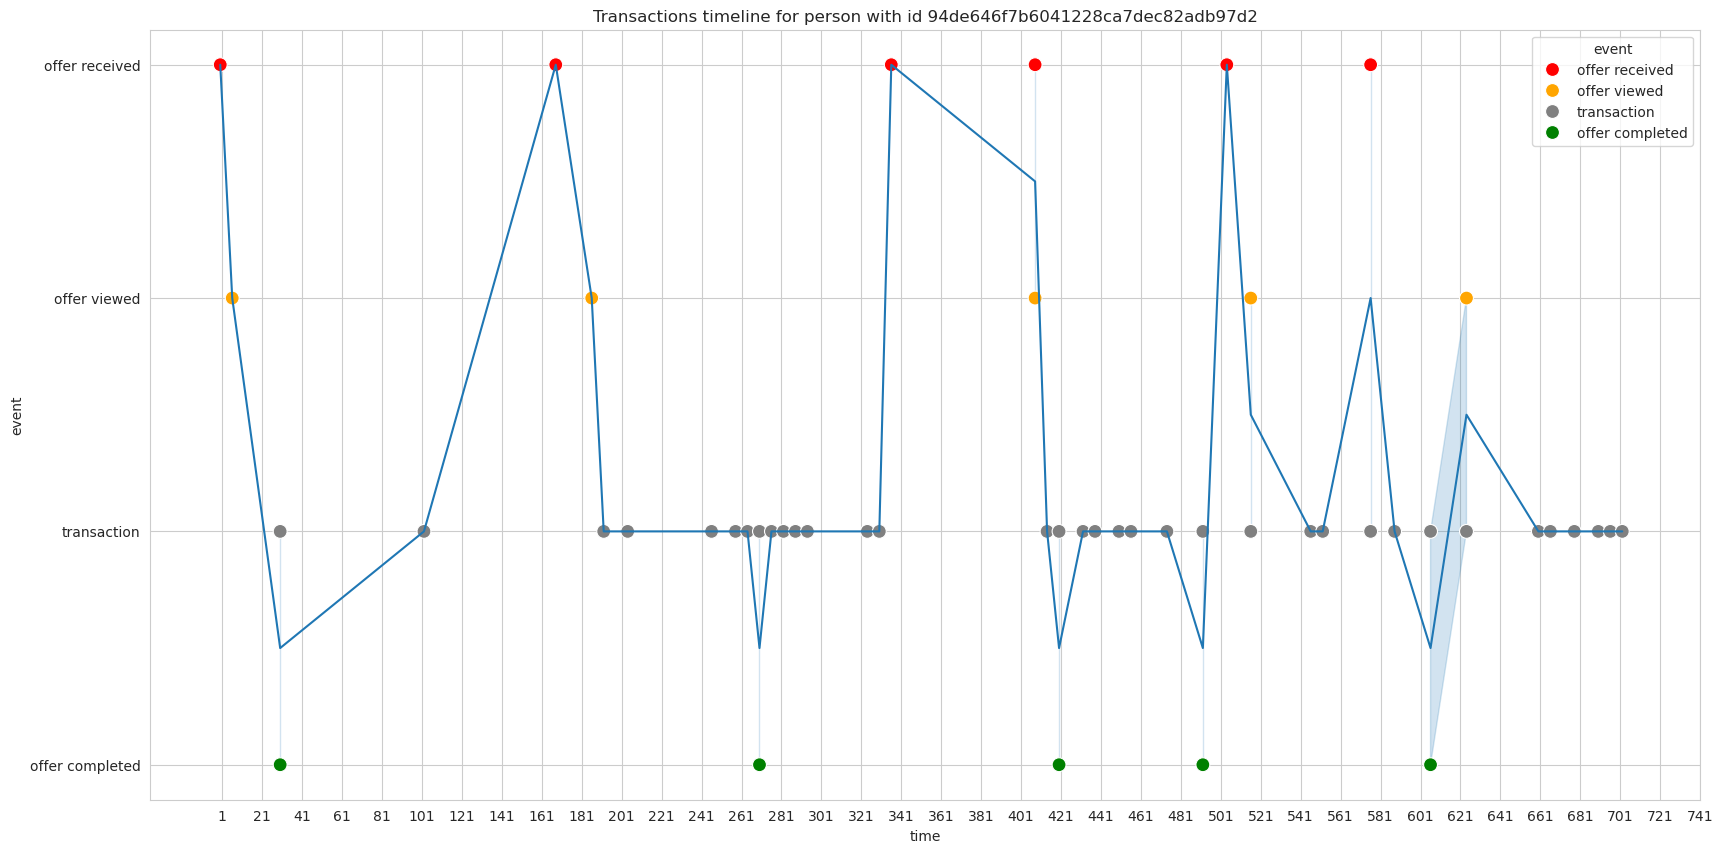

In [19]:

# person with the most number of transactions
person_with_max_transactions = t_df.loc[t_df['size'].idxmax(), 'person']
print(f'Person id with the maximum number of transactions in the dataset : {person_with_max_transactions}')

temp_df = transcript_df.loc[transcript_df['person'] == person_with_max_transactions]
display(temp_df)


sns.set_style('whitegrid')
fig, ax = plt.subplots()
sns.lineplot(
    data=temp_df,
    x='time',
    y='event',
)
sns.scatterplot(
    data=temp_df,
    x='time',
    y='event',
    hue='event',
    palette={
        'offer received': 'red',
        'offer viewed': 'orange',
        'offer completed':'green',
        'transaction': 'gray'
        },
    s=100
)
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_title(f'Transactions timeline for person with id {person_with_max_transactions}')
ax.set_xticks(range(1,750,20))
plt.show()


In [20]:
# person with the minimum number of transactions
person_with_min_transactions = t_df.loc[t_df['size'].idxmin(), 'person']
print(f'Person id with the maximum number of transactions in the dataset : {person_with_min_transactions}')

transcript_df.loc[transcript_df['person'] == person_with_min_transactions]

Person id with the maximum number of transactions in the dataset : da7a7c0dcfcb41a8acc7864a53cf60fb


,person,event,time,offer_id,amount
263150,da7a7c0dcfcb41a8acc7864a53cf60fb,transaction,582,None,0.35


- I can remove all entries for the users who has only one entry in the transcript in the dataset, since they all haven't been influenced by an offer.
- I can do this since I want only to include the offers that influenced a user. A user with only 1 entry in the transcript eith made only one transaction with a certain amount or recieved an offer without even viewing the offer.
- I can also remove all the entries of a user who has not viewed any offer i.e. has no offer viewed entry. this data is not relevant for the usecase studied.

### Remove the entries of users with no offers viewed

In [21]:
t_df = transcript_df.groupby('person', as_index=False)['event'].apply(
    lambda e: (e == 'offer viewed').sum()
).rename(columns={'event': '#viewed_offers'})

In [22]:
persons_with_no_viewed_offers_lst = t_df.loc[t_df['#viewed_offers'] == 0, 'person'].to_list()

In [23]:
transcript_df_viewed = transcript_df[~transcript_df['person'].isin(persons_with_no_viewed_offers_lst)]
print(f'Shape before cleaning : {transcript_df.shape}')
print(f'Shape after cleaning : {transcript_df_viewed.shape}')

Shape before cleaning : (306534, 5)
Shape after cleaning : (305264, 5)


### Converting event based data to tabular form

Steps:
- Group transcripts by person id and offer id.
- For each group loop through the offers.
- Append to 4 lists {person_id, offer_id, offer_viewed?, offer_competed?}
- Whenever we find an event received append person_id, offer_id, offer_viewed=0, offer_completed=0.
- Whenever we find offer_viewed make the last offer that wasn't viewed in the list = 1 (traverse the list from the end to the beginning)
- Whenever we find offer_completed make the last offer that wasn't completed in the list = 1 (traverse the list from the end to the beginning)

Assumption : Always associate the offer viewed and the offer completed events to the closest event that wasn't viewed or completed.
Also the events are travesed one group at a time.

I should end up with a dataframe that looks like this:

+-----------+----------+--------------+-----------------+
<br/>
| Person Id | Offer Id | Offer Viewed | Offer Completed |
<br/>
+-----------+----------+--------------+-----------------+

Finally remove all the offers that weren't viewed from the dataset.

In [24]:
# remove all transactions
transcript_df = transcript_df.loc[transcript_df['event'] != 'transaction']
transcript_df.head(5)

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [25]:
trans_df = {
    'person' : [],
    'offer_id' : [],
    'is_offer_viewed' : [],
    'is_offer_completed' : []
}

In [26]:
trans_grps = transcript_df.groupby(['person', 'offer_id'], as_index=True)

i = 0
for (person, offer_id), group_df in trans_grps:
    person_lst = []
    offer_id_lst = []
    offer_viewed_lst = []
    offer_completed_lst = []

    for _, row in group_df.iterrows():
        
        if row['event'] == 'offer received':
            person_lst.append(person)
            offer_id_lst.append(offer_id)
            offer_viewed_lst.append(0)
            offer_completed_lst.append(0)

        elif row['event'] == 'offer viewed':
            for i in range(len(offer_viewed_lst)-1, -1, -1):
                if offer_viewed_lst[i] == 0:
                    offer_viewed_lst[i] = 1
                else:
                    break
        elif row['event'] == 'offer completed':
            for i in range(len(offer_completed_lst)-1, -1, -1):
                if offer_completed_lst[i] == 0:
                    offer_completed_lst[i] = 1
                else:
                    break
        else:
            raise ValueError('Unknown value for event')
    
    trans_df['person'] = trans_df['person'] + person_lst
    trans_df['offer_id'] = trans_df['offer_id'] + offer_id_lst
    trans_df['is_offer_viewed'] = trans_df['is_offer_viewed'] + offer_viewed_lst
    trans_df['is_offer_completed'] = trans_df['is_offer_completed'] + offer_completed_lst

In [27]:
trans_df = pd.DataFrame(trans_df)
print(trans_df.shape)
trans_df.head(10)

(76277, 4)


,person,offer_id,is_offer_viewed,is_offer_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0
7,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1
9,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1,0


In [28]:
# view the offers for the person with the most offers
trans_df.loc[trans_df['person'] == '94de646f7b6041228ca7dec82adb97d2']

,person,offer_id,is_offer_viewed,is_offer_completed
44584,94de646f7b6041228ca7dec82adb97d2,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1
44585,94de646f7b6041228ca7dec82adb97d2,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0
44586,94de646f7b6041228ca7dec82adb97d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
44587,94de646f7b6041228ca7dec82adb97d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
44588,94de646f7b6041228ca7dec82adb97d2,f19421c1d4aa40978ebb69ca19b0e20d,1,1
44589,94de646f7b6041228ca7dec82adb97d2,fafdcd668e3743c1bb461111dcafc2a4,1,1


Now we remove all offers that weren't viewed and didn't influence the users

In [29]:
trans_df = trans_df.loc[trans_df['is_offer_viewed'] == 1]
trans_df.head(5)

,person,offer_id,is_offer_viewed,is_offer_completed
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0


## 🙍🏻‍♂️Profile

In [30]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [31]:
temp_df = profile.loc[profile['gender'].isna()]
gender_ids = temp_df.index
temp_df.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [32]:
temp_df = profile.loc[profile['income'].isna()]
income_ids = temp_df.index
temp_df.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [33]:
print(f'Is all ids with missing genders the same as the ones with missing incomes ?: {np.all(gender_ids == income_ids)}')

Is all ids with missing genders the same as the ones with missing incomes ?: True


In [34]:
temp_df = profile.loc[profile['income'].isna()]
print(temp_df.age.unique())

[118]


All ids with missing genders and income have the same age 118, which might be logical since old people might not fill their complete information during account setup on the rewards app

In [35]:
profile.describe(include='all')

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


Convert became_member_on to year, month, date

In [36]:
profile_df = profile.copy()

In [37]:
profile_df['became_member_on'] = profile_df['became_member_on'].astype(str)
print(profile_df['became_member_on'].dtype)
def change_date_format(date_str):
    out_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
    return out_str

profile_df['became_member_on'] = profile_df['became_member_on'].apply(change_date_format)

object


In [38]:
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], infer_datetime_format=True)

/tmp/ipykernel_11649/1212378716.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], infer_datetime_format=True)


In [39]:
profile_df['became_member_on_year'] = pd.DatetimeIndex(profile_df['became_member_on']).year
profile_df['became_member_on_month'] = pd.DatetimeIndex(profile_df['became_member_on']).month
profile_df['became_member_on_day'] = pd.DatetimeIndex(profile_df['became_member_on']).day
profile_df = profile_df.drop('became_member_on', axis=1)

In [40]:
profile_df.head(10)

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,NaN,2017,10,2
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
9,None,118,8974fc5686fe429db53ddde067b88302,NaN,2016,11,22


In [41]:
profile_df.describe(include='all')

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
count,14825,17000.000000,17000,14825.000000,17000.000000,17000.000000,17000.000000
unique,3,NaN,17000,NaN,NaN,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN
freq,8484,NaN,1,NaN,NaN,NaN,NaN
mean,NaN,62.531412,NaN,65404.991568,2016.635000,6.683529,15.881176
std,NaN,26.738580,NaN,21598.299410,1.177624,3.487098,8.775390
min,NaN,18.000000,NaN,30000.000000,2013.000000,1.000000,1.000000
25%,NaN,45.000000,NaN,49000.000000,2016.000000,4.000000,8.000000
50%,NaN,58.000000,NaN,64000.000000,2017.000000,7.000000,16.000000
75%,NaN,73.000000,NaN,80000.000000,2017.000000,10.000000,23.000000


It is clear from the above description that:
- 2175 users haven't specified their age.
- 2175 users haven't specified their income (still don't know if they are the same as the ones who didn't specify their age)
- We have users that became members in the region from 2013 to 2018, I can try to derive info such as if the user being older has an effect on whether or not he might accept the offer.


In [42]:
temp_df = profile_df.loc[:, ['age', 'income']]
temp_df = temp_df[temp_df['age'].notna()]
temp_df = temp_df[temp_df['income'].notna()]
temp_df.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [43]:
temp_df['age'] = temp_df['age'].astype('category')
temp_df.describe(include='all')

,age,income
count,14825.0,14825.000000
unique,84.0,NaN
top,58.0,NaN
freq,408.0,NaN
mean,NaN,65404.991568
std,NaN,21598.299410
min,NaN,30000.000000
25%,NaN,49000.000000
50%,NaN,64000.000000
75%,NaN,80000.000000


Text(0.5, 1.0, 'age vs income')

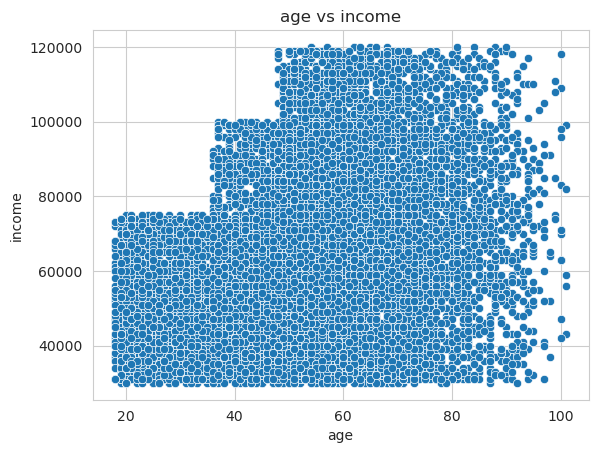

In [44]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=temp_df.age, y=temp_df.income)
ax.set_title('age vs income')


From the above plot it is clear that the average income increases as the age of the user increasers and thus we can divide the people into three categories based on the age and income of different users
- below 40
- between 40 and 50
- above 50

In [45]:
def categorize_users(age):
    if age <= 40:
        return '<=40'
    elif age > 40 and age <= 50:
        return '40-50'
    else: 
        return '>50'

In [46]:
temp_df['age_category'] = temp_df['age'].apply(categorize_users)
temp_df.describe(include='all')

,age,income,age_category
count,14825.0,14825.000000,14825
unique,84.0,NaN,3
top,58.0,NaN,>50
freq,408.0,NaN,9132
mean,NaN,65404.991568,NaN
std,NaN,21598.299410,NaN
min,NaN,30000.000000,NaN
25%,NaN,49000.000000,NaN
50%,NaN,64000.000000,NaN
75%,NaN,80000.000000,NaN


get the average income for each group and set it to the clients with None groups

In [47]:
avg_incomes = pd.Series(temp_df.groupby('age_category').income.mean())

In [48]:
def impute_income(row):
    age = row['age']
    income = row['income']
    if pd.isna(income):
        if age <= 40:
            return avg_incomes['<=40']
        elif age > 40 and age <= 50:
            return avg_incomes['40-50']
        else:
            return avg_incomes['>50']
    else:
        return income

In [49]:
profile_df['income'] = profile_df.apply(impute_income, axis=1)

In [50]:
profile_df.describe(include='all')

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
count,14825,17000.000000,17000,17000.000000,17000.000000,17000.000000,17000.000000
unique,3,NaN,17000,NaN,NaN,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN
freq,8484,NaN,1,NaN,NaN,NaN,NaN
mean,NaN,62.531412,NaN,66069.420094,2016.635000,6.683529,15.881176
std,NaN,26.738580,NaN,20243.750515,1.177624,3.487098,8.775390
min,NaN,18.000000,NaN,30000.000000,2013.000000,1.000000,1.000000
25%,NaN,45.000000,NaN,51000.000000,2016.000000,4.000000,8.000000
50%,NaN,58.000000,NaN,68000.000000,2017.000000,7.000000,16.000000
75%,NaN,73.000000,NaN,76000.000000,2017.000000,10.000000,23.000000


### Imputing values for gender

One idea to impute missing values in gender is to use predictive modelling. A Decision tree model can be used to predict the gender of the user given its age and income.
I decided to impute missing data and remove it since we have only 17000 rows of data so losing ~2000 rows of the dataset is regarded as a great loss of information.

In [51]:
profile_df.head(10)

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,70598.226018,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,70598.226018,2017,8,4
5,M,68,e2127556f4f64592b11af22de27a7932,70000.000000,2018,4,26
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,70598.226018,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,70598.226018,2017,10,2
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.000000,2018,2,9
9,None,118,8974fc5686fe429db53ddde067b88302,70598.226018,2016,11,22


In [52]:
temp_profile_df_notna = profile_df.loc[profile_df['gender'].notna(), ['age', 'income', 'gender']]
temp_profile_df_na = profile_df.loc[profile_df['gender'].isna(), ['age', 'income', 'gender']]
display(temp_profile_df_na.head(10))
display(temp_profile_df_notna.head(10))

,age,income,gender
0,118,70598.226018,None
2,118,70598.226018,None
4,118,70598.226018,None
6,118,70598.226018,None
7,118,70598.226018,None
9,118,70598.226018,None
10,118,70598.226018,None
11,118,70598.226018,None
17,118,70598.226018,None
23,118,70598.226018,None


,age,income,gender
1,55,112000.0,F
3,75,100000.0,F
5,68,70000.0,M
8,65,53000.0,M
12,58,51000.0,M
13,61,57000.0,F
14,26,46000.0,M
15,62,71000.0,F
16,49,52000.0,M
18,57,42000.0,M


In [53]:
from sklearn import tree
y = temp_profile_df_notna.gender
X = temp_profile_df_notna.drop('gender', axis=1)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)

In [54]:
temp_profile_df_na['gender'] = clf.predict(temp_profile_df_na.drop('gender', axis=1))
temp_profile_df_na.head(5)

,age,income,gender
0,118,70598.226018,F
2,118,70598.226018,F
4,118,70598.226018,F
6,118,70598.226018,F
7,118,70598.226018,F


In [55]:
profile_df.loc[profile_df['gender'].isna(), ['gender']] = temp_profile_df_na['gender']

In [56]:
display(profile_df.head(5))
display(profile_df.tail(5))
profile_df.describe(include='all')

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
0,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15
2,F,118,38fe809add3b4fcf9315a9694bb96ff5,70598.226018,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9
4,F,118,a03223e636434f42ac4c3df47e8bac43,70598.226018,2017,8,4


,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018,6,4
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018,7,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2017,1,26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016,3,7
16999,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,22


,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
count,17000,17000.000000,17000,17000.000000,17000.000000,17000.000000,17000.000000
unique,3,NaN,17000,NaN,NaN,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN
freq,8484,NaN,1,NaN,NaN,NaN,NaN
mean,NaN,62.531412,NaN,66069.420094,2016.635000,6.683529,15.881176
std,NaN,26.738580,NaN,20243.750515,1.177624,3.487098,8.775390
min,NaN,18.000000,NaN,30000.000000,2013.000000,1.000000,1.000000
25%,NaN,45.000000,NaN,51000.000000,2016.000000,4.000000,8.000000
50%,NaN,58.000000,NaN,68000.000000,2017.000000,7.000000,16.000000
75%,NaN,73.000000,NaN,76000.000000,2017.000000,10.000000,23.000000


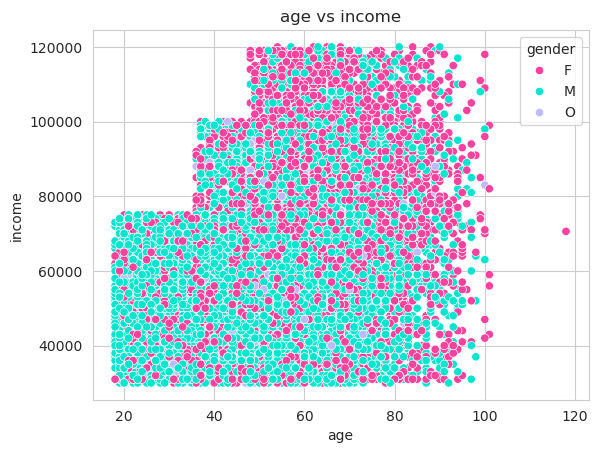

In [57]:
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=profile_df.age, 
    y=profile_df.income, 
    hue=profile_df.gender, 
    palette=dict(F='#F9429E', M='#03E5CE', O='#BDBBFF')
)
ax.set_title('age vs income')
plt.show()

it appears from the plot that there is no clear relation in the dataset between the gender and the income of the reward application users

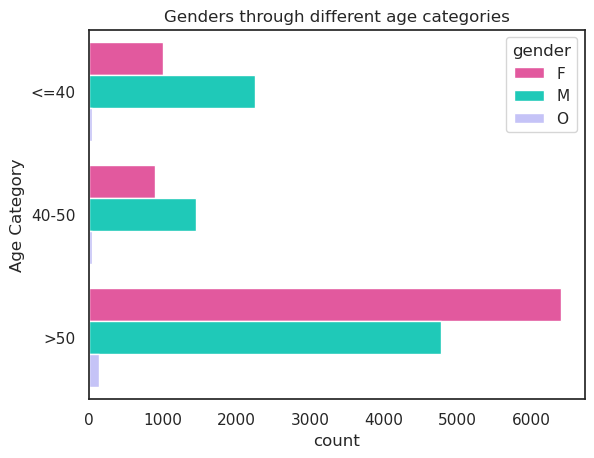

In [58]:
# Todo : make a stacked barplot that maps age to gender to see which use the application more for different age categories
temp_df = profile_df.loc[:, ['age', 'gender']]
sns.set(style='white')
temp_df['age_category'] = temp_df.age.apply(categorize_users)
temp_df.drop('age', axis=1, inplace=True)
sns.countplot(
    data = temp_df,
    y='age_category',
    hue='gender',
    palette=dict(F='#F9429E', M='#03E5CE', O='#BDBBFF'),
    order=['<=40', '40-50', '>50']
)

plt.ylabel('Age Category')
plt.title('Genders through different age categories')
plt.show()


Probably imputing the values of missing genders with all Females since they were all the same with age 118 caused the number of females to be more than the number of males for the age category >50

## 🖇Dataframe Joining

In [59]:
print(f"trans_df shape : {trans_df.shape}")
trans_df.head(5)

trans_df shape : (58941, 4)


,person,offer_id,is_offer_viewed,is_offer_completed
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0


Add person information and offer information to each row in the dataset.

In [60]:
profile_df = profile_df.rename({"id": "person"}, axis=1)
profile_df.head(3)

,gender,age,person,income,became_member_on_year,became_member_on_month,became_member_on_day
0,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15
2,F,118,38fe809add3b4fcf9315a9694bb96ff5,70598.226018,2018,7,12


In [61]:
# join person information
dataset = pd.merge(profile_df, trans_df, on='person')
print(f"Dataset shape : {dataset.shape}")
dataset.head(5)

Dataset shape : (58941, 10)


,gender,age,person,income,became_member_on_year,became_member_on_month,became_member_on_day,offer_id,is_offer_viewed,is_offer_completed
0,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0
1,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1
2,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,2906b810c7d4411798c6938adc9daaa5,1,0
3,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,fafdcd668e3743c1bb461111dcafc2a4,1,1
4,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,fafdcd668e3743c1bb461111dcafc2a4,1,0


In [62]:
portfolio_df = portfolio_df.reset_index()
portfolio_df = portfolio_df.rename(dict(id='offer_id'), axis=1)
print(f"Portofolio df shape : {portfolio_df.shape}")
portfolio_df.head(5)

Portofolio df shape : (10, 9)


,offer_id,reward,difficulty,duration,offer_type,email,mobile,web,social
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,True,True,False,True
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,True,True,True,True
2,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,True,True,True,False
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,True,True,True,False
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,True,False,True,False


In [63]:
# join offer information
dataset = pd.merge(dataset, portfolio_df, on='offer_id')

In [64]:
print(f"Dataset shape : {dataset.shape}")
dataset = dataset.drop('is_offer_viewed', axis=1)
dataset.head(10)

Dataset shape : (58941, 18)


,gender,age,person,income,became_member_on_year,became_member_on_month,became_member_on_day,offer_id,is_offer_completed,reward,difficulty,duration,offer_type,email,mobile,web,social
0,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,5,20,10,discount,True,False,True,False
1,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,2298d6c36e964ae4a3e7e9706d1fb8c2,1,3,7,7,discount,True,True,True,True
2,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,2906b810c7d4411798c6938adc9daaa5,0,2,10,7,discount,True,True,True,False
3,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,fafdcd668e3743c1bb461111dcafc2a4,1,2,10,10,discount,True,True,True,True
4,F,118,68be06ca386d4c31939f3a4f0e3dd783,70598.226018,2017,2,12,fafdcd668e3743c1bb461111dcafc2a4,0,2,10,10,discount,True,True,True,True
5,F,118,38fe809add3b4fcf9315a9694bb96ff5,70598.226018,2018,7,12,5a8bc65990b245e5a138643cd4eb9837,0,0,0,3,informational,True,True,False,True
6,F,118,38fe809add3b4fcf9315a9694bb96ff5,70598.226018,2018,7,12,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5,7,bogo,True,True,True,False
7,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,5a8bc65990b245e5a138643cd4eb9837,0,0,0,3,informational,True,True,False,True
8,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,5,7,bogo,True,True,True,False
9,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,ae264e3637204a6fb9bb56bc8210ddfd,1,10,10,7,bogo,True,True,False,True


Checking if there are duplicate rows with the same features but different or same class labels.
- if they have the same class label we can leave only 1 of the rows.
- if they have  different class labels then the given features aren't enough for the target value, for simplicity, I decide to remove these columns if they are not too much.

In [65]:
dataset = dataset.drop(['person', 'offer_id'], axis=1)
dataset.head(2)

,gender,age,income,became_member_on_year,became_member_on_month,became_member_on_day,is_offer_completed,reward,difficulty,duration,offer_type,email,mobile,web,social
0,F,118,70598.226018,2017,2,12,0,5,20,10,discount,True,False,True,False
1,F,118,70598.226018,2017,2,12,1,3,7,7,discount,True,True,True,True


In [66]:
print(f'Dataset Shape before dropping duplicates : {dataset.shape}')
dataset = dataset.drop_duplicates(keep='first')
print(f'Dataset Shape after dropping duplicates : {dataset.shape}')

Dataset Shape before dropping duplicates : (58941, 15)
Dataset Shape after dropping duplicates : (48270, 15)


Make sure that no two rows with the same features have the different labels

In [67]:
features = dataset.drop(['is_offer_completed'], axis=1).columns.to_list()

In [68]:
temp_df = dataset.groupby(features, as_index=False)['is_offer_completed'].size()
temp_df.loc[temp_df['size'] == 2]

,gender,age,income,became_member_on_year,became_member_on_month,became_member_on_day,reward,difficulty,duration,offer_type,email,mobile,web,social,size
131,F,20,35000.0,2017,2,6,10,10,7,bogo,True,True,False,True,2
145,F,20,46000.0,2017,10,11,5,5,5,bogo,True,True,True,True,2
388,F,22,45000.0,2017,11,15,2,10,10,discount,True,True,True,True,2
457,F,22,73000.0,2014,6,12,10,10,7,bogo,True,True,False,True,2
550,F,24,37000.0,2017,5,31,10,10,7,bogo,True,True,False,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46982,O,55,84000.0,2017,12,29,5,5,7,bogo,True,True,True,False,2
46988,O,56,33000.0,2018,5,1,10,10,7,bogo,True,True,False,True,2
47018,O,57,91000.0,2017,8,23,10,10,5,bogo,True,True,True,True,2
47026,O,58,73000.0,2015,8,31,5,20,10,discount,True,False,True,False,2


There are 956 rows in which the input feature aren't enough to give information about whether the offer would be completed or not, for simplicity I decide to remove these rows.

In [69]:
print(f'Dataset Shape before removing rows with same features but different labels : {dataset.shape}')
dataset = dataset.drop_duplicates(subset=features, keep=False)
print(f'Dataset Shape after removing rows with same features but different labels : {dataset.shape}')

Dataset Shape before removing rows with same features but different labels : (48270, 15)
Dataset Shape after removing rows with same features but different labels : (46358, 15)


Save dataset before processing in a csv file to avoid having to process the data every time

In [70]:
dataset = dataset.reset_index(drop=True)
print(f'Dataset Shape : {dataset.shape}')
dataset.head(10)

Dataset Shape : (46358, 15)


,gender,age,income,became_member_on_year,became_member_on_month,became_member_on_day,is_offer_completed,reward,difficulty,duration,offer_type,email,mobile,web,social
0,F,118,70598.226018,2017,2,12,0,5,20,10,discount,True,False,True,False
1,F,118,70598.226018,2017,2,12,1,3,7,7,discount,True,True,True,True
2,F,118,70598.226018,2018,7,12,0,0,0,3,informational,True,True,False,True
3,F,118,70598.226018,2018,7,12,0,5,5,7,bogo,True,True,True,False
4,F,75,100000.000000,2017,5,9,0,0,0,3,informational,True,True,False,True
5,F,75,100000.000000,2017,5,9,1,5,5,7,bogo,True,True,True,False
6,F,75,100000.000000,2017,5,9,1,10,10,7,bogo,True,True,False,True
7,F,75,100000.000000,2017,5,9,1,5,5,5,bogo,True,True,True,True
8,F,118,70598.226018,2017,8,4,0,5,20,10,discount,True,False,True,False
9,F,118,70598.226018,2017,8,4,0,0,0,4,informational,True,True,True,False


In [71]:
filename = 'dataset.csv'
dataset.to_csv(filename)

Load dataset from csv file

In [72]:
dataset = pd.read_csv('dataset.csv', index_col=0)
dataset.head(5)

,gender,age,income,became_member_on_year,became_member_on_month,became_member_on_day,is_offer_completed,reward,difficulty,duration,offer_type,email,mobile,web,social
0,F,118,70598.226018,2017,2,12,0,5,20,10,discount,True,False,True,False
1,F,118,70598.226018,2017,2,12,1,3,7,7,discount,True,True,True,True
2,F,118,70598.226018,2018,7,12,0,0,0,3,informational,True,True,False,True
3,F,118,70598.226018,2018,7,12,0,5,5,7,bogo,True,True,True,False
4,F,75,100000.000000,2017,5,9,0,0,0,3,informational,True,True,False,True


check for dataset imbalance

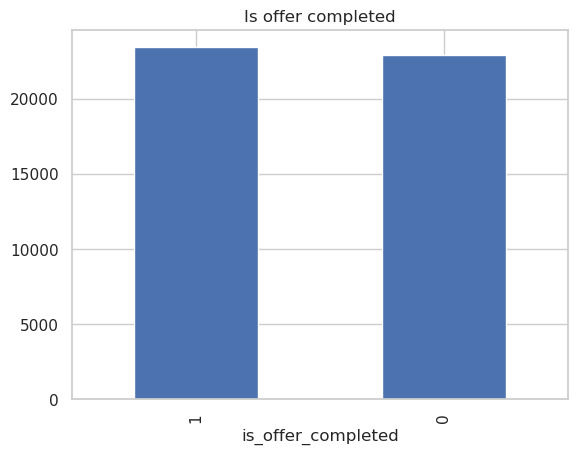

In [73]:
sns.set_style('whitegrid')
dataset['is_offer_completed'].value_counts().plot(kind='bar')
plt.title('Is offer completed')
plt.show()

From the above plot it is apparent that the dataset is balanced before splitting

In [74]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46358 entries, 0 to 46357
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  46358 non-null  object 
 1   age                     46358 non-null  int64  
 2   income                  46358 non-null  float64
 3   became_member_on_year   46358 non-null  int64  
 4   became_member_on_month  46358 non-null  int64  
 5   became_member_on_day    46358 non-null  int64  
 6   is_offer_completed      46358 non-null  int64  
 7   reward                  46358 non-null  int64  
 8   difficulty              46358 non-null  int64  
 9   duration                46358 non-null  int64  
 10  offer_type              46358 non-null  object 
 11  email                   46358 non-null  bool   
 12  mobile                  46358 non-null  bool   
 13  web                     46358 non-null  bool   
 14  social                  46358 non-null  boo

Change datatypes for efficiency

In [75]:
dtypes_dict = {
    'gender' : 'category',
    'age' : 'int8',
    'income' : 'float32',
    'became_member_on_year': 'int16',
    'became_member_on_month' : 'int8',
    'became_member_on_day' : 'int8',
    'is_offer_completed' : 'int8',
    'reward' : 'int16',
    'difficulty' : 'int16',
    'duration' : 'int16',
    'offer_type' : 'category',
    'email' : 'bool',
    'mobile' : 'bool',
    'web' : 'bool',
    'social' : 'bool'

}

In [76]:
dataset = dataset.astype(dtypes_dict)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46358 entries, 0 to 46357
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gender                  46358 non-null  category
 1   age                     46358 non-null  int8    
 2   income                  46358 non-null  float32 
 3   became_member_on_year   46358 non-null  int16   
 4   became_member_on_month  46358 non-null  int8    
 5   became_member_on_day    46358 non-null  int8    
 6   is_offer_completed      46358 non-null  int8    
 7   reward                  46358 non-null  int16   
 8   difficulty              46358 non-null  int16   
 9   duration                46358 non-null  int16   
 10  offer_type              46358 non-null  category
 11  email                   46358 non-null  bool    
 12  mobile                  46358 non-null  bool    
 13  web                     46358 non-null  bool    
 14  social                  463

In [77]:
dataset.head(2)

,gender,age,income,became_member_on_year,became_member_on_month,became_member_on_day,is_offer_completed,reward,difficulty,duration,offer_type,email,mobile,web,social
0,F,118,70598.226562,2017,2,12,0,5,20,10,discount,True,False,True,False
1,F,118,70598.226562,2017,2,12,1,3,7,7,discount,True,True,True,True


# 💪 Training

## Dataset Splitting

In [78]:
y = dataset['is_offer_completed']
X = dataset.drop(['is_offer_completed'], axis=1)

Since the dataset is not too large we do a 90% train, 10% test split

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

In [80]:
X_train = X_train.reset_index(level=0, drop=True)
X_train.head(3)

,gender,age,income,became_member_on_year,became_member_on_month,became_member_on_day,reward,difficulty,duration,offer_type,email,mobile,web,social
0,M,64,70000.0,2017,3,5,2,10,10,discount,True,True,True,True
1,F,28,58000.0,2017,11,11,0,0,4,informational,True,True,True,False
2,M,42,84000.0,2016,12,28,10,10,5,bogo,True,True,True,True


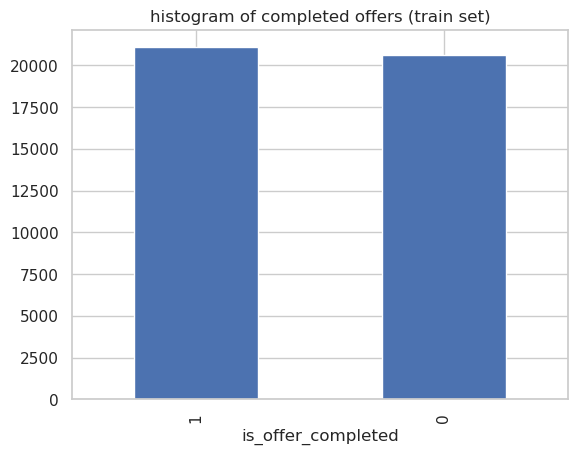

In [81]:
y_train = y_train.reset_index(level=0, drop=True)
y_train.value_counts().plot(kind='bar')
plt.title('histogram of completed offers (train set)')
plt.show()

Save the train dataset to a csv file

In [82]:
if not os.path.exists(PROCESSED_DATA_DIR):
    os.mkdir(PROCESSED_DATA_DIR)
if not os.path.exists(os.path.join(PROCESSED_DATA_DIR, 'train')):
    os.mkdir(os.path.join(PROCESSED_DATA_DIR, 'train'))
pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(PROCESSED_DATA_DIR, 'train', 'data.csv'), index=False)

In [83]:
X_test = X_test.reset_index(level=0, drop=True)
X_test.head(3)

,gender,age,income,became_member_on_year,became_member_on_month,became_member_on_day,reward,difficulty,duration,offer_type,email,mobile,web,social
0,M,68,71000.0,2014,7,22,3,7,7,discount,True,True,True,True
1,M,74,89000.0,2015,9,8,10,10,5,bogo,True,True,True,True
2,F,51,81000.0,2016,12,27,2,10,7,discount,True,True,True,False


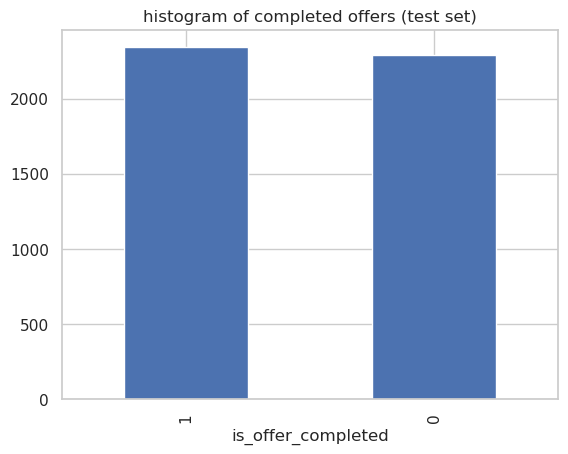

In [84]:
y_test = y_test.reset_index(level=0, drop=True)
y_test.value_counts().plot(kind='bar')
plt.title('histogram of completed offers (test set)')
plt.show()

Save test set to a csv file

In [85]:
if not os.path.exists(PROCESSED_DATA_DIR):
    os.mkdir(PROCESSED_DATA_DIR)
if not os.path.exists(os.path.join(PROCESSED_DATA_DIR, 'test')):
    os.mkdir(os.path.join(PROCESSED_DATA_DIR, 'test'))
pd.concat([y_test, X_test], axis=1).to_csv(os.path.join(PROCESSED_DATA_DIR, 'test', 'data.csv'), index=False)

## Uploading Data to S3

In [86]:
# Upload metadata
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX = 'Project/starbucks-dataset'
# ---
DATASET_LOCAL_DIR = PROCESSED_DATA_DIR

In [87]:
dataset_dir_path = sagemaker_session.upload_data(
    path=DATASET_LOCAL_DIR,
    bucket=BUCKET,
    key_prefix=PREFIX
)

print(f"Dataset directory path on S3 : {dataset_dir_path}")

Dataset directory path on S3 : s3://sagemaker-us-east-1-951515567130/Project/starbucks-dataset


## Benchmarking and Training Model using Autogluon AutoML container from sagemaker

Some of the following code is adapted from the sagemakers examples from aws sagemaker examples public repo
https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/autogluon_tabular/Amazon_Tabular_Classification_AutoGluon.ipynb

In [88]:
%%capture --no-stderr
!pip install sagemaker ipywidgets --upgrade --quiet

In [89]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [90]:
train_model_id, train_model_version, train_scope = (
    "autogluon-classification-ensemble",
    "*",
    "training",
)

In [91]:
training_instance_type = "ml.m5.large"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune. In tabular case, however, the pre-trained model tarball is dummy and fine-tune means training from scratch.
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'autogluon-classification-ensemble' with wildcard version identifier '*'. You can pin to version '2.0.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [92]:
# Sample training data is available in this bucket
training_data_bucket = sess.default_bucket()
training_data_prefix = "Project/starbucks-dataset/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"
print(training_dataset_s3_path)

output_bucket = sess.default_bucket()
output_prefix = "Project/starbucks-tabular-binary"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

s3://sagemaker-us-east-1-951515567130/Project/starbucks-dataset/


In [93]:
# Retrieve the default hyper-parameters for fine-tuning the model
from sagemaker import hyperparameters
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["auto_stack"] = "True"
hyperparameters['eval_metric'] = 'accuracy'
hyperparameters['presets'] = 'best_quality'
hyperparameters['save_space'] = "True"
hyperparameters['verbosity'] = 2
print(hyperparameters)

{'eval_metric': 'accuracy', 'presets': 'best_quality', 'auto_stack': 'True', 'num_bag_folds': '0', 'num_bag_sets': '1', 'num_stack_levels': '0', 'refit_full': 'False', 'set_best_to_refit_full': 'False', 'save_space': 'True', 'verbosity': 2}


In [94]:
training_job_name = name_from_base(f"{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=40*60,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)


# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit({"training": training_dataset_s3_path}, logs=True, job_name=training_job_name)

INFO:sagemaker:Creating training-job with name: autogluon-classification-ensemble-train-2024-05-05-03-27-30-233


2024-05-05 03:27:30 Starting - Starting the training job...
2024-05-05 03:27:46 Starting - Preparing the instances for training...
2024-05-05 03:28:14 Downloading - Downloading input data...
2024-05-05 03:28:44 Downloading - Downloading the training image......
2024-05-05 03:29:44 Training - Training image download completed. Training in progress.2024-05-05 03:29:49,125 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2024-05-05 03:29:49,128 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-05-05 03:29:49,136 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"auto_stack":"True","eval_metric":"accuracy","num_bag_folds":"0","num_bag_sets":"1","num_stack_levels":"0","presets":"best_quality","refit_full":"False","save_space":"True","set_best_to_refit_full":"False","verbosity":2}', 'SM_USER_ENTRY_POINT': 'transfer_le

#0110.8108#011 = Validation score   (accuracy)
#0111.28s#011 = Training   runtime
#0110.03s#011 = Validation runtime
Fitting model: RandomForestGini ...
#0110.7936#011 = Validation score   (accuracy)
#0119.09s#011 = Training   runtime
#0110.22s#011 = Validation runtime
Fitting model: RandomForestEntr ...
#0110.7896#011 = Validation score   (accuracy)
#0118.44s#011 = Training   runtime
#0110.21s#011 = Validation runtime
Fitting model: CatBoost ...
#0110.826#011 = Validation score   (accuracy)
#01125.06s#011 = Training   runtime
#0110.03s#011 = Validation runtime
Fitting model: ExtraTreesGini ...
#0110.7884#011 = Validation score   (accuracy)
#0115.72s#011 = Training   runtime
#0110.26s#011 = Validation runtime
Fitting model: ExtraTreesEntr ...
#0110.7868#011 = Validation score   (accuracy)
#0115.95s#011 = Training   runtime
#0110.25s#011 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 5: early stopping
#0110.8076#011 = Validation score   (accuracy)
#01

### Benchmark table

In [95]:
# The following table data is manually copied from the training job logs
import pandas as pd

models_metadata = {
    'Model' : [
        'LightGBMXT',
        'LightGBM',
        'RandomForestGini',
        'RandomForestEntr',
        'CatBoost',
        'ExtraTreesGini',
        'ExtraTreesEntr',
        'NeuralNetFastAI',
        'XGBoost',
        'NeuralNetTorch',
        'LightGBMLarge',
        'Weighted_Ensemble_L2'
    ],
    'Training runtime' : [
        4.55,
        1.32,
        7.38,
        7.95,
        13.75,
        5.23,
        5.45,
        39.2,
        3.21,
        106.13,
        2.26,
        1.09
    ],
    'Validation runtime' : [
        0.07,
        0.03,
        0.21,
        0.21,
        0.02,
        0.24,
        0.26,
        0.05,
        0.03,
        0.05,
        0.04,
        0.0
    ],
    'Validation accuracy' : [
        0.8148,
        0.812,
        0.7828,
        0.784,
        0.8204,
        0.7888,
        0.7872,
        0.7972,
        0.8008,
        0.81,
        0.8132,
        0.8272
    ]
}

df = pd.DataFrame(models_metadata).sort_values(by='Validation accuracy', ascending=False)
df = df.reset_index(drop=True)
df

,Model,Training runtime,Validation runtime,Validation accuracy
0,Weighted_Ensemble_L2,1.09,0.00,0.8272
1,CatBoost,13.75,0.02,0.8204
2,LightGBMXT,4.55,0.07,0.8148
3,LightGBMLarge,2.26,0.04,0.8132
4,LightGBM,1.32,0.03,0.8120
5,NeuralNetTorch,106.13,0.05,0.8100
6,XGBoost,3.21,0.03,0.8008
7,NeuralNetFastAI,39.20,0.05,0.7972
8,ExtraTreesGini,5.23,0.24,0.7888
9,ExtraTreesEntr,5.45,0.26,0.7872


# 🧪 Evaluation

Loading the model artifacts

In [97]:
training_job_name = 'autogluon-classification-ensemble-train-2024-05-05-03-27-30-233'
tabular_estimator = Estimator.attach(training_job_name)


2024-05-05 03:33:46 Starting - Preparing the instances for training
2024-05-05 03:33:46 Downloading - Downloading the training image
2024-05-05 03:33:46 Training - Training image download completed. Training in progress.
2024-05-05 03:33:46 Uploading - Uploading generated training model
2024-05-05 03:33:46 Completed - Training job completed


Deploying an endpoint for the best model

In [98]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

In [99]:
endpoint_name = name_from_base(f"{train_model_id}-endpoint")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-951515567130/Project/starbucks-tabular-binary/output/autogluon-classification-ensemble-train-2024-05-05-03-27-30-233/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/autogluon/inference/classification/v1.0.0/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-951515567130/sagemaker-jumpstart-2024-05-05-03-43-32-532/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2024-05-05-03-43-32-532
INFO:sagemaker:Creating endpoint-config with name autogluon-classification-ensemble-endpo-2024-05-05-03-43-32-532
INFO:sagemaker:Creating endpoint with name autogluon-classification-ensemble-endpo-2024-05-05-03-43-32-532


------!

Quering the endpoint using the test set

In [108]:
bucket = sess.default_bucket()
test_data_prefix = "Project/starbucks-dataset/test"
test_data_file_name = "data.csv"

boto3.client("s3").download_file(
    bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name
)

In [109]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv(test_data_file_name, header=0)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(10)


The test dataset contains 4636 examples and 15 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14
0,1,M,68,71000.00,2014,7,22,3,7,7,discount,True,True,True,True
1,1,M,74,89000.00,2015,9,8,10,10,5,bogo,True,True,True,True
2,1,F,51,81000.00,2016,12,27,2,10,7,discount,True,True,True,False
3,1,F,49,80000.00,2016,7,4,10,10,5,bogo,True,True,True,True
4,1,F,97,52000.00,2017,9,29,5,5,7,bogo,True,True,True,False
5,1,F,63,100000.00,2013,10,5,5,5,7,bogo,True,True,True,False
6,0,M,76,85000.00,2016,7,14,3,7,7,discount,True,True,True,True
7,0,F,118,70598.23,2018,7,17,0,0,4,informational,True,True,True,False
8,1,M,59,85000.00,2015,11,29,5,5,7,bogo,True,True,True,False
9,0,M,63,34000.00,2017,10,1,10,10,5,bogo,True,True,True,True


In [110]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)


# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)


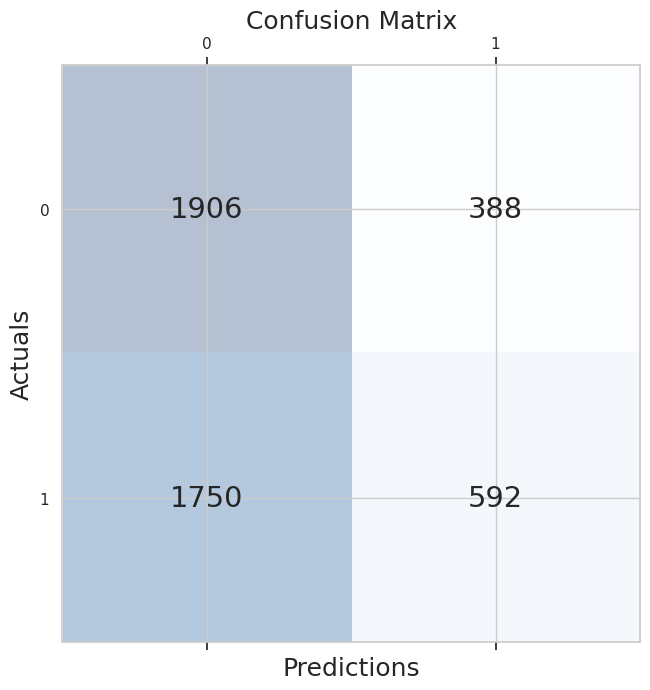

In [111]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [112]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1 = f1_score(ground_truth_label.values, predict_label)

print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy * 100} % {newline}"
    f"{bold}F1 {unbold}: {eval_f1 * 100} %{newline}"
)

Evaluation result on test data:
accuracy_score: 53.88265746333045 % 
F1 : 35.64118001204094 %



In [113]:
query = {
    'gender' : ['M'],
    'age' : [18],
    'income' : [5000],
    'became_member_on_year' : [2017],
    'became_member_on_month' : [11],
    'became_member_on_day' : [5],
    'reward': [5],
    'difficulty' : [20],
    'duration' : [10],
    'offer_type': ['discount'],
    'email': [True],
    'mobile': [True],
    'web' : [True],
    'social' : [True]    
}

query_keys = list(query.keys())
query_list = list(query.values())
print(query_list)

[['M'], [18], [5000], [2017], [11], [5], [5], [20], [10], ['discount'], [True], [True], [True], [True]]


In [116]:
query_response_batch = query_endpoint(
    pd.DataFrame(query).to_csv(header=False, index=False).encode("utf-8")
)
predict_prob = parse_response(query_response_batch)[0]

print(f'{bold}Person Information{unbold}{newline}')
for i in range(6):
    print(f'{bold}{query_keys[i]} : {unbold}{query_list[i][0]}')

print()
print(f'{bold}Offer Information{unbold}{newline}')
for i in range(6,14):
    print(f'{bold}{query_keys[i]} : {unbold}{query_list[i][0]}')

print()
print('-*-'*15)
# print(f'{bold}Is the Offer expected to be Completed ? : {unbold} {"Yes" if label else "No"} {bold} with Probability : {unbold} {predict_prob[label]}')

Person Information

gender : M
age : 18
income : 5000
became_member_on_year : 2017
became_member_on_month : 11
became_member_on_day : 5

Offer Information

reward : 5
difficulty : 20
duration : 10
offer_type : discount
email : True
mobile : True
web : True
social : True

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


# 🚮 Cleaning Environment

In [117]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2024-05-05-03-43-32-532
INFO:sagemaker:Deleting endpoint configuration with name: autogluon-classification-ensemble-endpo-2024-05-05-03-43-32-532
INFO:sagemaker:Deleting endpoint with name: autogluon-classification-ensemble-endpo-2024-05-05-03-43-32-532
